In [2]:
# import des librairies
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

path = '/home/..../Bureau/PFL'

In [3]:
t0 = time.time()
print("Temps de l'import :")
filename_train = 'train.csv'
filename_test = 'test.csv'

data_train = pd.read_csv(path+'/'+filename_train)
data_test = pd.read_csv(path+'/'+filename_test)

print("%0.3fs" % (time.time() - t0))
print("===============================")
print("Taille train : " + str(data_train.shape[0]))

Temps de l'import :
29.474s
Taille train : 7377418


In [5]:
print("Statistiques sur les chansons :")
print("Nombre de chansons uniques dans train : " + str(data_train['song_id'].nunique()))
print("Nombre de chansons uniques dans test : " + str(data_test['song_id'].nunique()))
merge_train_et_test = np.intersect1d(data_train['song_id'].unique(), data_test['song_id'].unique())

print("Chansons uniques présentes dans Train et Test : {}" .format(merge_train_et_test.shape[0]))
print(round((data_test['song_id'].nunique()- merge_train_et_test.shape[0])/data_test['song_id'].nunique(),4))



Statistiques sur les chansons :
Nombre de chansons uniques dans train : 359966
Nombre de chansons uniques dans test : 224753
Chansons uniques présentes dans Train et Test : 164880
0.2664


Il existe 26.64% de chansons uniques dans Test et non présentes dans le jeu d'apprentissage

### SONGS

In [4]:
songs = pd.read_csv(path+'/'+'songs.csv')
print('Nombre de chansons : {}'.format(songs['song_id'].nunique()))
songs.head(5)

Nombre de chansons : 2296320


,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


On dénombre 2 296 320 chansons décrites par 7 variables : le nom de la chanson, la durée, le genre, l'artiste, le compositeur et la langue.
A noter qu'une chanson peut avoir plusieurs genres.

In [4]:
min_song_length_sec = songs['song_length'].min() / 1000  # durée en milisecondes
max_song_length_sec = songs['song_length'].max() / 1000
print('Durée de la plus courte chanson : {}s'.format(min_song_length_sec))
print('Durée de la plus longue chanson : {}s'.format(max_song_length_sec))

Durée de la plus courte chanson : 0.185s
Durée de la plus longue chanson : 12173.85s


Bizarre ! Une chanson de moins d'une seconde et la plus longue dure plus de 3h.

In [35]:
min_length_song = songs.iloc[songs['song_length'].idxmin()]
max_length_song = songs.iloc[songs['song_length'].idxmax()]
print(min_length_song)
print('='*70)
print(max_length_song)

song_id        kLdsd0eUT6Pp3EDG4nEGBxabSN5b9CUSuaE3H/B5w78=
song_length                                             185
genre_ids                                               921
artist_name                       Blockbuster Sound Effects
composer                                                NaN
lyricist                                                NaN
language                                                 52
Name: 677186, dtype: object
song_id        DCdid/1HvuvKitGXNUg+R89Z9T7bHQquDeUra4fBzZU=
song_length                                        12173850
genre_ids                                               940
artist_name                                Jason Stephenson
composer                                   Jason Stephenson
lyricist                                                NaN
language                                                 -1
Name: 778210, dtype: object


La plus courte chanson est de Blockbuster Sound Effects. En faisant une recherche sur Deezer, on s'aperçoit en effet qu'il s'agit d'effets musicaux très courts.
Quant à Jason Stephenson, c'est un compositeur de musique de méditation/relaxation.

In [36]:
print('Langues : {}'.format(songs['language'].unique()))
print('Nombre de langues : {}'.format(songs['language'].unique().shape[0]))

Langues : [ 3. 31. 52. 17. 10. -1. 24. 59. 45. 38. nan]
Nombre de langues : 11


Les chansons sont composées en 10 langues diffèrentes.

### Etude de la popularité des chansons

Dans cette étape, on croise le jeu de données d'apprentissage et la table des chansons.
L'idée est de classer les chansons selon leur popularité mais aussi d'étudier les variables qui influent à la répétition ou non des chansons.

In [5]:
log_chansons = data_train[['msno','song_id','target']].merge(songs,on='song_id')
log_chansons_g = log_chansons[['song_id', 'target']].groupby(['song_id']).agg(['mean','count'])

In [6]:
log_chansons_g.reset_index(inplace=True)
log_chansons_g.columns = list(map(''.join, log_chansons_g.columns.values))
log_chansons_g.columns = ['song_id', 'chance_replay', 'occurence']
song_data = log_chansons_g.merge(songs, on='song_id')

#### Le nombre maximal d'occurrence 

In [7]:
song_data['occurence'].max()

13973

Etudions les éléments qui affectent le plus le nombre d'écoutes (replay) ?

In [9]:
song_data.head(3)

,song_id,chance_replay,occurence,song_length,genre_ids,artist_name,composer,lyricist,language
0,+++2AEoM0d8iZTdbnAjUm35bnGKGMXdZJSv4rrWK6JQ=,0,1,223921,921,รวมศิลปิน,Chackkrit Muckkanaso,Tadakorn; Narongvit Techatanawat,45
1,++/ACCkEN/+VtgrJxEqeRgRmV4y8pcarDJ9T/yRAi1E=,0,2,271302,465,Variété Française,NaN,NaN,52
2,++/lJNswCU+za2pYB0cWIbGL5UzWIKtfweX20+GImZA=,0,3,221413,786|947,愛的音樂盒,NaN,NaN,-1


In [10]:
type('genre_ids')

str

In [6]:
# Fonction qui permet de compter le nombre de valeurs : exemple, on peut avoir 2 nombres séparés par | pour le genre

def cnt(a):
    if type(a) != str:
        return 1
    else:
        return 1 + a.count('|')

#### Etude sur les genres, les compositeurs et lyriques

In [7]:
song_data['number_of_genres'] = song_data['genre_ids'].apply(cnt)  # compte le nombre de genres par chanson
song_data['number_of_composers'] = song_data['composer'].apply(cnt)
song_data['number_of_lyricists'] = song_data['lyricist'].apply(cnt)

In [8]:
genres_max = song_data['number_of_genres'].max()
composers_max = song_data['number_of_composers'].max()
lyricists_max = song_data['number_of_lyricists'].max()

print('Nombre maximal de genres : {} \nNombre maximal de compositeurs : {} \nNombre maximal de lyriques : {}'.format(genres_max, composers_max, lyricists_max))


Nombre maximal de genres : 8 
Nombre maximal de compositeurs : 51 
Nombre maximal de lyriques : 23


In [10]:
max_song_composers = song_data.iloc[song_data['number_of_composers'].idxmax()]
print('Chanson ayant le plus de compositeurs : ' + '\n'+ '\n' + str(max_song_composers[['artist_name', 'composer', 'lyricist', 'number_of_composers',
                     'number_of_lyricists']]))

Chanson ayant le plus de compositeurs : 

artist_name                                                       SHINee
composer               Korean Lyrics by Kim| Jong Hyun (12.5%) Harvey...
lyricist                          Andreas "Quiz" Romdhane| Savan Kotecha
number_of_composers                                                   51
number_of_lyricists                                                    2
Name: 309485, dtype: object


In [11]:
max_song_genres = song_data.iloc[song_data['number_of_genres'].idxmax()]
print('Chanson ayant le plus de genres : ' + '\n'+ '\n' + str(max_song_genres[['artist_name', 'composer', 'number_of_genres',
                     'number_of_lyricists']]))

Chanson ayant le plus de genres : 

artist_name                        証聲音樂圖書館 ECHO MUSIC
composer               Joseph Mohr;Franz Xaver Gruber
number_of_genres                                    8
number_of_lyricists                                 1
Name: 25490, dtype: object


#### Etude de l'influence de la langue 

In [20]:
languages = song_data['language'].unique()

language_count = []
language_occurence = []
language_chance_replay = []

for l in languages:
    if not np.isnan(l):
        songs_with_language = song_data[song_data['language'] == l] # pour chaque langue on compte le nombre de chansons
        language_count.append(songs_with_language.shape[0]) # le nombre total de chansons dans la langue
        count = songs_with_language['occurence'].sum() 
        language_occurence.append(count) # total d'occurence de la langue
        language_chance_replay.append(songs_with_language['chance_replay'].sum() / count) # chance de répétition
        
        
    else:
        songs_with_language = song_data[pd.isnull(song_data['language'])]
        language_count.append(songs_with_language.shape[0])
        count = songs_with_language['occurence'].sum()
        language_occurence.append(count)
        language_chance_replay.append(songs_with_language['chance_replay'].sum() / count)
        
        # le nombre de chansons ayant la même langue / le nombre total d'occurence des chansons ayant la même langue donne
        # le pourceentage de chance de répétition
        

In [24]:
print('Langues : {}'.format(languages))

Langues : [45. 52. -1.  3. 10. 24. 31. 17. 59. 38. nan]


In [25]:
languages[10] = 90 # On affecte la valeur 90 (au hasard) à la langue 'nan'

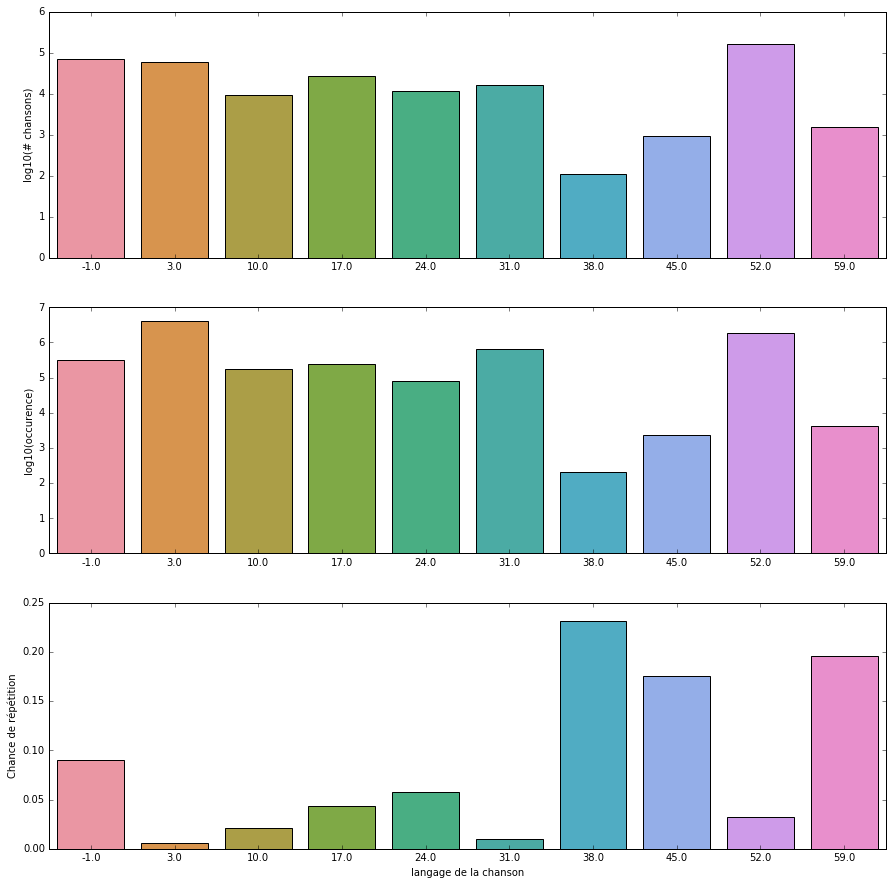

In [21]:
fig = plt.figure(figsize=(15, 15)) 

ax1 = plt.subplot(3,1,1)
sns.barplot(languages, np.log10(language_count)) # log en base 10 pour l'échelle
ax1.set_ylabel('log10(# chansons)')

ax2 = plt.subplot(3,1,2)
sns.barplot(languages, np.log10(language_occurence))
ax2.set_ylabel('log10(occurence)')


ax3 = plt.subplot(3,1,3)
sns.barplot(languages,language_chance_replay)
ax3.set_ylabel('Chance de répétition')
ax3.set_xlabel('langage de la chanson')

plt.show()


Les chansons de langue '3', '10', '31' ont moins de chance de réécoute. Cependant elles représentent plus d'écoute.
On dénombre plus de chansons (5000) dans la langue '52'.

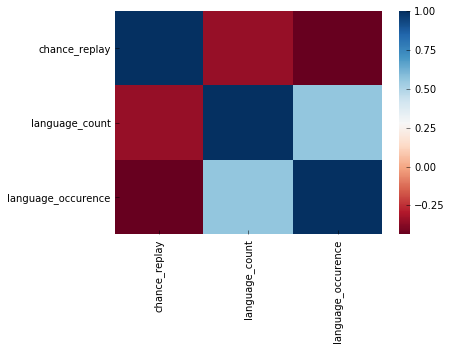

In [22]:
l = pd.DataFrame({'language_count' :language_count,'language_occurence' : language_occurence, 'chance_replay' : language_chance_replay})
corr = l.corr()
sns.heatmap(corr,cmap= 'RdBu', xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

Le nombre de chansons dans une langue et le nombre d'occurences influent négativement à la chance de répétition.

#### Etude de l'influence de la durée de la chanson

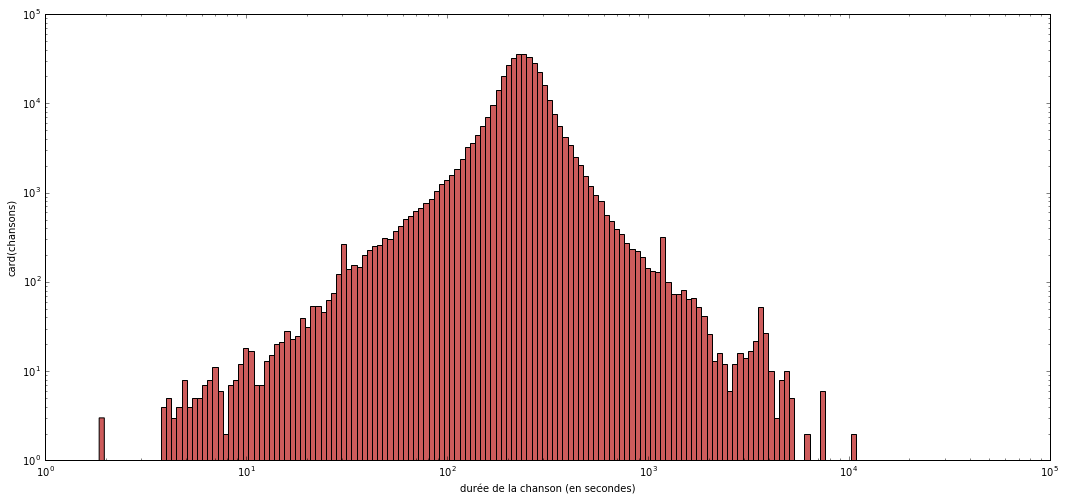

In [23]:
plt.figure(figsize=(18,8))
k = np.logspace(np.log10(min_song_length_sec)+1,np.log10(max_song_length_sec),150)

sns.distplot(song_data['song_length']/1000, bins=k, hist_kws={"alpha": 1}, kde=False, color='indianred')
plt.xlabel('durée de la chanson (en secondes)')
plt.ylabel('card(chansons)')
plt.yscale('log')
plt.xscale('log')
plt.show()

Il existe beaucoup de chansons dont leur durée est supérieure à 1000s ~ 16 minutes. La durée est néanmoins fortement concentrée entre 2 et moins de 6 minutes.

In [116]:
k.shape

(150,)

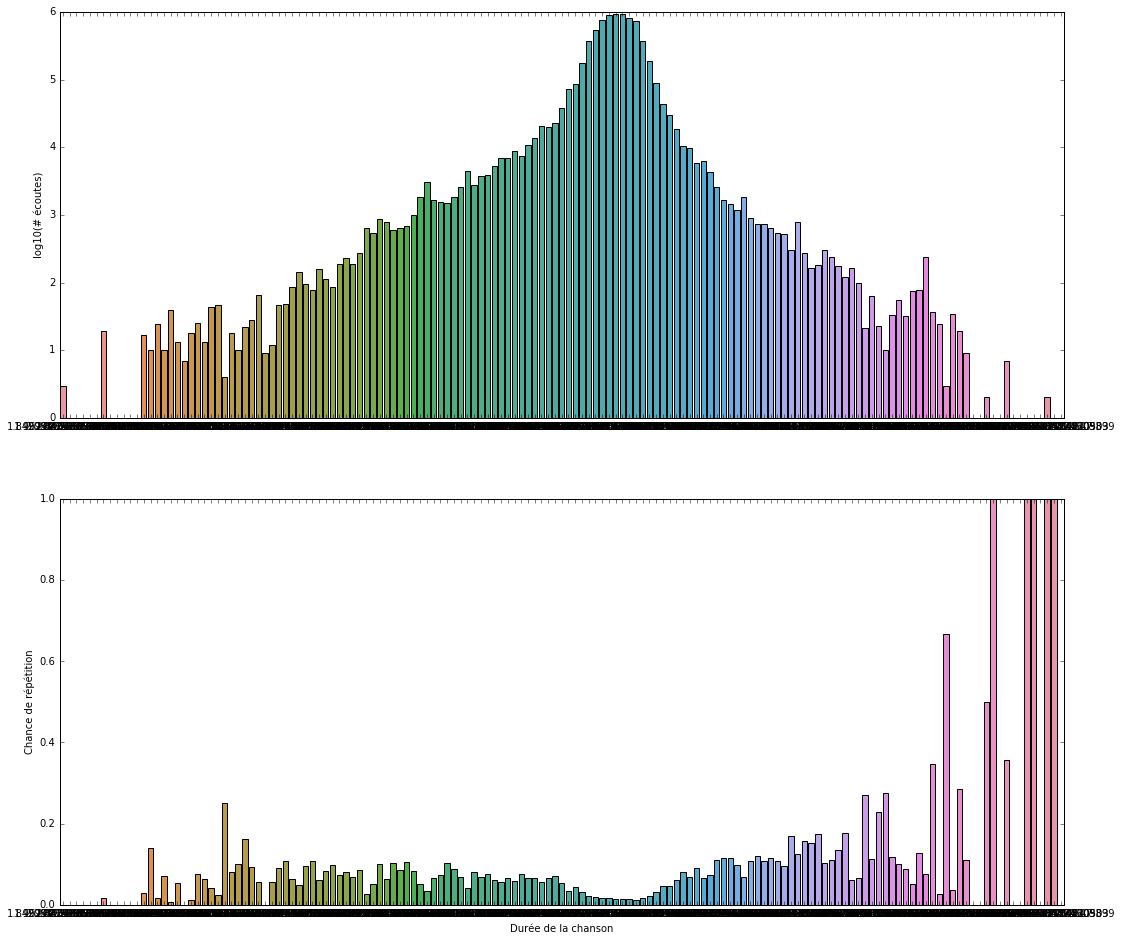

In [24]:
d_chance_rpt = []
d_occurence = []

durée = list(range(k.shape[0]-1))
song_data['sub_durée'] = pd.cut(song_data['song_length']/1000, bins=k, labels=durée)  # subdivision de la durée

for d in durée :
    sub_durée_d = song_data[song_data['sub_durée']==d]
    count = sub_durée_d['occurence'].sum()
    d_occurence.append(count)
    
    if count != 0:
        d_chance_rpt.append(sub_durée_d['chance_replay'].sum() / count)
    else:                                               # si la durée n'est pas dans k
        d_chance_rpt.append(0)
    
plt.figure(figsize=(18, 16)) 

ax211 = plt.subplot(2,1,1)
sns.barplot(x=k[durée],y=np.log10(d_occurence))
ax211.set_ylabel('log10(# écoutes)')

ax212 = plt.subplot(2,1,2)
sns.barplot(x = k[durée],y = d_chance_rpt)
ax212.set_ylabel('Chance de répétition')
ax212.set_xlabel('Durée de la chanson')

plt.show()

Il est clair que les chansons qui ont une durée supérieure à la moyenne, ont de forte chance d'étre réécoutées.
En effet, les gens qui ont écouté la chanson de Jason Stephenson l'ont réécoutée au moins une seconde fois.

In [25]:
print(song_data['artist_name'].value_counts()[:10]) # 10 artistes les représentés dans la base

Various Artists       17080
証聲音樂圖書館 ECHO MUSIC     3997
貴族精選                   1211
霹靂布袋戲劇集原聲帶              937
張學友 (Jacky Cheung)      869
陳奕迅 (Eason Chan)        832
鄧麗君 (Teresa Teng)       786
Michael Jackson         657
Armin van Buuren        577
王菲 (Faye Wong)          536
Name: artist_name, dtype: int64


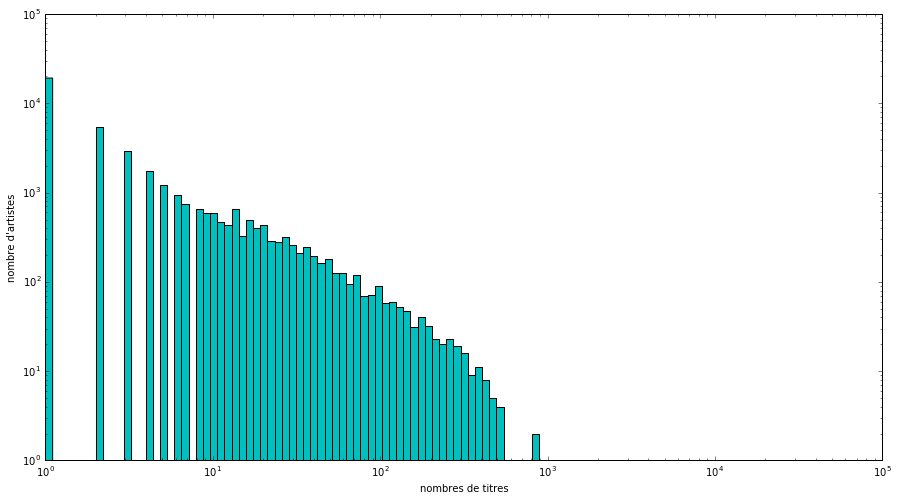

In [31]:
max_titre = song_data['artist_name'].value_counts().max()

plt.figure(figsize=(15,8))

k_titre = np.logspace(0,np.log10(max_titre),100)

sns.distplot(song_data['artist_name'].value_counts(), bins=k_titre, kde=False, hist_kws={"alpha": 1}, color='c')
plt.xlabel('nombres de titres')
plt.ylabel("nombre d'artistes")
plt.yscale('log')
plt.xscale('log')

membersplt.show()

### Croisement Train-Songs-Members

In [7]:
members = pd.read_csv(path+'/'+'members.csv')
df1 = data_train.merge(songs,on='song_id')
song_train_mem = df1.merge(members, on= 'msno', how='left')

In [10]:
song_train_mem.isnull().sum()/song_train_mem.isnull().count()

msno                      0.000000
song_id                   0.000000
source_system_tab         0.003368
source_screen_name        0.056226
source_type               0.002920
target                    0.000000
song_length               0.000000
genre_ids                 0.016041
artist_name               0.000000
composer                  0.227128
lyricist                  0.430873
language                  0.000005
city                      0.000000
bd                        0.000000
gender                    0.401425
registered_via            0.000000
registration_init_time    0.000000
expiration_date           0.000000
dtype: float64

43% des données manquantes après croisement de (train-songs_members) concernent les paroliers et 40% le sexe des membres ...

Nous allons remplacer les données manquantes par ...0. Elles concernent essentiellement le sexe, les paroliers ... des variables catégorielles !

In [8]:
song_train_mem = song_train_mem.fillna(value=0)

In [36]:
song_train_mem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377304 entries, 0 to 7377303
Data columns (total 18 columns):
msno                      object
song_id                   object
source_system_tab         object
source_screen_name        object
source_type               object
target                    int64
song_length               int64
genre_ids                 object
artist_name               object
composer                  object
lyricist                  object
language                  float64
city                      int64
bd                        int64
gender                    object
registered_via            int64
registration_init_time    int64
expiration_date           int64
dtypes: float64(1), int64(7), object(10)
memory usage: 1.0+ GB


In [9]:
#song_train_mem['registration_init_time'] = pd.to_datetime(song_train_mem['registration_init_time'], format = '%Y%m%d')
#song_train_mem['annee_enregristrement'] = song_train_mem['registration_init_time'].dt.year

song_train_mem["annee_enregristrement"] = song_train_mem.registration_init_time.apply(lambda  x: str(x)[0:4])
song_train_mem['mois_enregristrement'] = song_train_mem.registration_init_time.apply(lambda  x: str(x)[4:6])
song_train_mem['jour_enregristrement'] = song_train_mem.registration_init_time.apply(lambda  x: str(x)[6:8])

song_train_mem["annee_expiration"] = song_train_mem.expiration_date.apply(lambda  x: str(x)[0:4])
song_train_mem['mois_expiration'] = song_train_mem.expiration_date.apply(lambda  x: str(x)[4:6])
song_train_mem['jour_expiration'] = song_train_mem.expiration_date.apply(lambda  x: str(x)[6:8])

song_train_mem.head(3)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,annee_enregristrement,mois_enregristrement,jour_enregristrement,annee_expiration,mois_expiration,jour_expiration
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471,359,Bastille,Dan Smith| Mark Crew,...,0,7,20120102,20171005,2012,01,02,2017,10,05
1,e5Ezre9HPuPos+CXQXtmo32E/hHIZTMmo6jG3yRf6UA=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-playlist,1,206471,359,Bastille,Dan Smith| Mark Crew,...,female,3,20150513,20171019,2015,05,13,2017,10,19
2,pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,Online playlist more,online-playlist,0,206471,359,Bastille,Dan Smith| Mark Crew,...,male,4,20151220,20170930,2015,12,20,2017,09,30


In [10]:
for c in song_train_mem.select_dtypes(include = ['object']).columns:
    song_train_mem[c] = song_train_mem[c].astype('category')    # on change le type des objets en catégorie
    
for c in song_train_mem.select_dtypes(include = ['category']).columns:  
    song_train_mem[c] = song_train_mem[c].cat.codes   # codage des variables catégorielles
    
song_train_mem = song_train_mem.drop(['registration_init_time','expiration_date'],1)

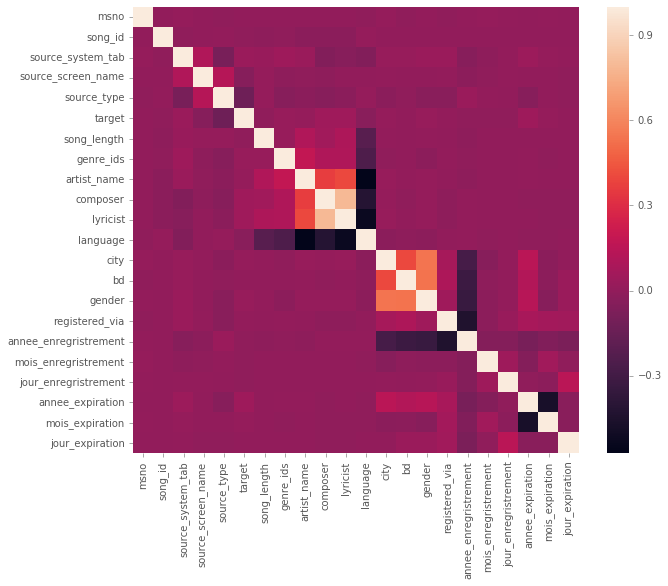

In [14]:
plt.figure(figsize = [10,8])
sns.heatmap(song_train_mem.corr())
plt.show()

Après l'encodage des variables catégorielles, il s'avère que certaines variables sont moyennement corrélées.
Ces corrélations semblent cohérentes : il s'agit du compositeur et le parolier.

#### Variable target

In [14]:
dfp  = song_train_mem[['target', 'msno']].groupby(['target']).agg(['count'])
dfp.reset_index(inplace=True)
dfp.columns = list(map(''.join, dfp.columns.values))
dfp.columns = ['target', 'count']
dfp

,target,count
0,0,3662694
1,1,3714610


Target est bien réparti !